In [1]:
# Start writing code here...
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

In [4]:
data = pd.read_csv("Data/international-airline-passengers.csv",engine='python',skipfooter=3)
data.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m-%d')
data.set_index(['Month'], inplace=True)

In [8]:
data.tail()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


Text(0.5, 0, 'Date and Time')

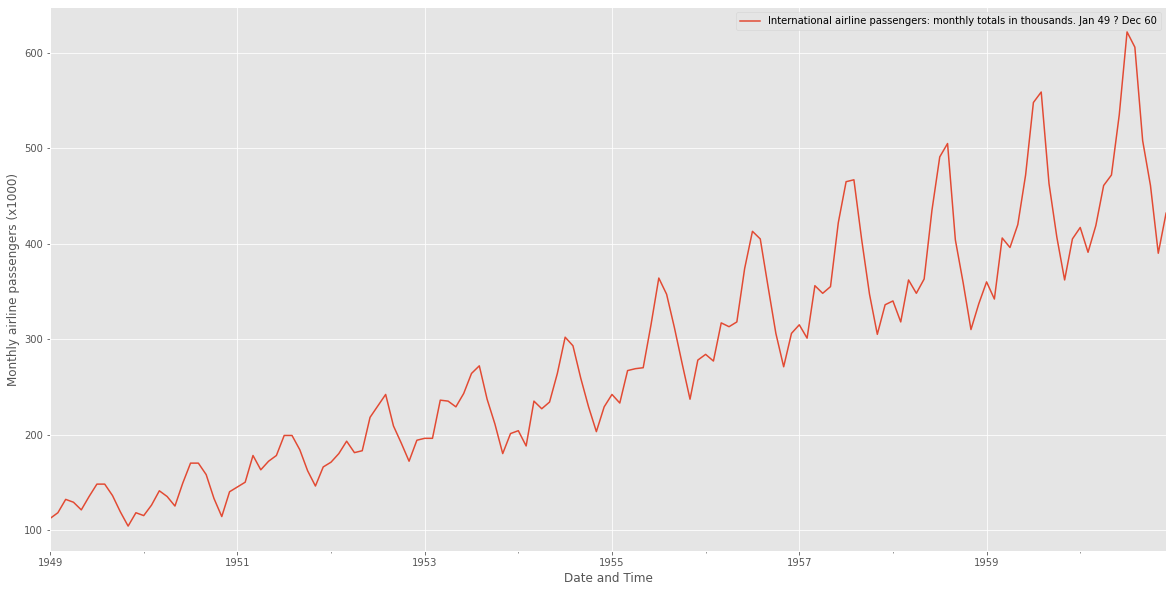

In [11]:
data.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date and Time')

**ARIMA**
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q):

* **p** is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* **d** is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* **q** is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series.

In [12]:
q = d = range(0,2) # Define the d and q parameters to take any value between 0 and 1
p = range(0,4) # Define the p parameters to take any value between 0 and 3


# Generate all different combinations of p, q and q triplets 
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal  p, q and q triplets

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
train_data = data['1949-01-01':'1959-12-01'] # 11 years of data
test_data = data['1960-01-01':'1960-12-01'] # 1 one year of data

In [17]:
warnings.filterwarnings("ignore")
AIC = []
SARIMAX_model  = []

for param in pdq: 
    for param_seasonal in seasonal_pdq:

        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                            )
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

  F =   2.3253832517132409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37657D+00    |proj g|=  1.93017D-01

At iterate    5    f=  2.32889D+00    |proj g|=  2.56605D-02

At iterate   10    f=  2.32306D+00    |proj g|=  1.48160D-02

At iterate   15    f=  2.32256D+00    |proj g|=  1.27612D-03

At iterate   20    f=  2.32222D+00    |proj g|=  8.57152D-03

At iterate   25    f=  2.32212D+00    |proj g|=  2.75393D-03

At iterate   30    f=  2.32212D+00    |proj g|=  2.63550D-04

At iterate   35    f=  2.32212D+00    |proj g|=  3.26973D-04

At iterate   40    f=  2.32212D+00    |proj g|=  7.47046D-05

At iterate   45    f=  2.32212D+00    |proj g|=  8.22144D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

In [15]:

print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


The smallest AIC is 618.2055117193103 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [18]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     52      1     0     0   5.164D-05   2.909D+00
  F =   2.9094625872170576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65786D+00    |proj g|=  4.76210D-02

At iterate    5    f=  2.65335D+00    |proj g|=  1.28358D-02

At iterate   10    f=  2.64955D+00    |proj g|=  4.96963D-03

At iterate   15    f=  2.64940D+00    |proj g|=  3.10252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    

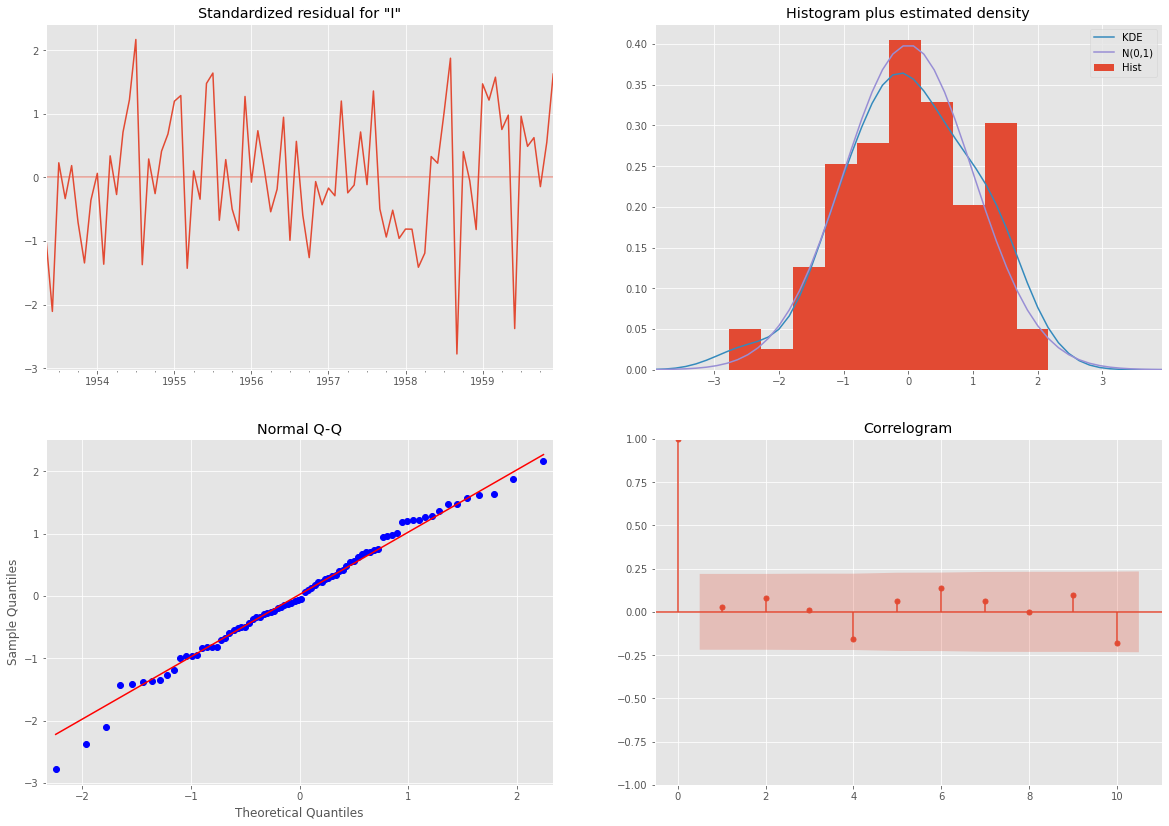

In [19]:

results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [22]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [23]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [24]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493878
1960-02-01    397.831749
1960-03-01    460.856707
1960-04-01    449.448973
1960-05-01    474.553320
1960-06-01    537.848537
1960-07-01    614.884965
1960-08-01    628.210020
1960-09-01    519.334392
1960-10-01    462.252396
1960-11-01    412.160938
1960-12-01    452.661075
Freq: MS, Name: predicted_mean, dtype: float64


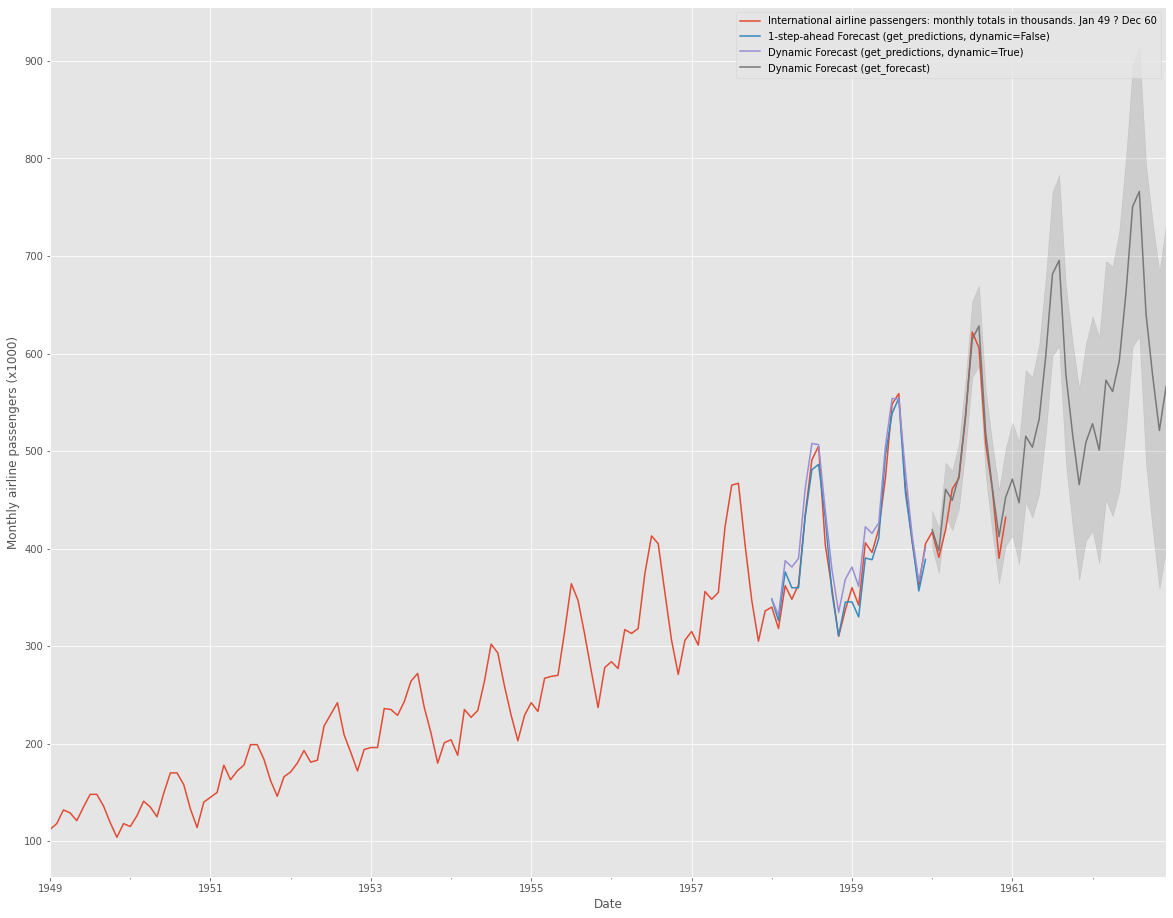

In [27]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [28]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f5f90ba1-3290-463e-8fc6-44108f4fa21b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>